# JWST Data Analysis Use Case: Crowded Field PSF Photometry

**Data**: NIRCam simulated images obtained using MIRAGE (https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator) and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of the Large Magellanic Cloud (LMC) Astrometric Calibration Field. For this example, we use Level-2 images (.cal, calibrated but unrectified) for 1 SW NIRCam detector of module B (i.e., "NRCB1") for two wide filters: F115W and F200W.

PSF Photometry is obtained using two different methods:
* single effective PSF (ePSF)
* single model PSF obtained from WebbPSF
    
## To Do:

* Create a function to determine the size of the grid to adopt when creating a grid of ePSFs (dependent on the number of PSF stars in each region of the grid)
* Create a function to build a grid of ePSFs
* speed up the PSF photometry process to perform the reduction on the whole field
* Perform PSF photometry using a grid of ePSFs and a grid of model PSFs from WebbPSF

### Import basic functions, astropy, numpy, and matplotlib

In [3]:
import os
import sys
import time

import numpy as np

import pandas as pd


from astropy import wcs
from astropy import units as u
from astropy.io import fits
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.visualization import simple_norm
from astropy.nddata import Cutout2D, NDData
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord, match_coordinates_sky

from photutils import CircularAperture, EPSFBuilder, find_peaks
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.centroids import centroid_2dg

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

### Load and Display the two images

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


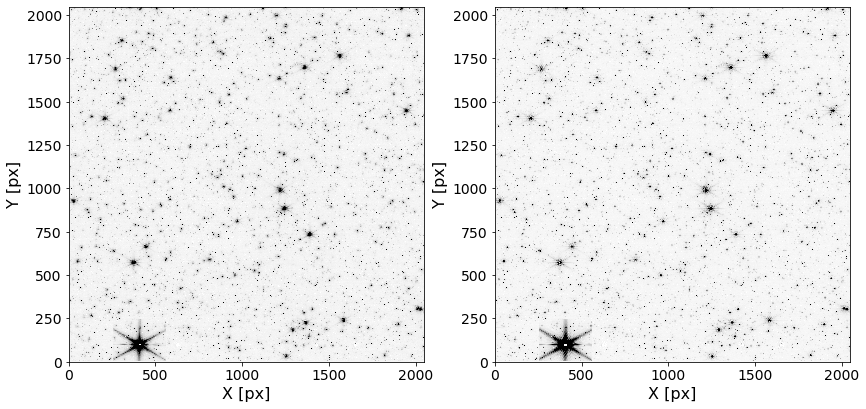

In [5]:
image_f115w = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/psf_photometry/jw01072001001_01101_00001_nrcb1_cal.fits'
image_f200w = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/psf_photometry/jw01072001001_01101_00005_nrcb1_cal.fits'

im_f115w = fits.open(image_f115w)
data_f115w_sb = im_f115w[1].data
imh_f115w = im_f115w[1].header
imwcs_f115w = wcs.WCS(imh_f115w)

im_f200w = fits.open(image_f200w)
data_f200w_sb = im_f200w[1].data
imh_f200w = im_f200w[1].header
imwcs_f200w = wcs.WCS(imh_f200w)

plt.figure(figsize=(14,14))

ax1 = plt.subplot(1,2,1)

norm_f115w = simple_norm(data_f115w_sb, 'sqrt', percent=99.)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(data_f115w_sb, norm=norm_f115w, cmap = 'Greys')

ax2 = plt.subplot(1,2,2)
norm_f200w = simple_norm(data_f200w_sb, 'sqrt', percent=99.)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(data_f200w_sb, norm=norm_f200w, cmap = 'Greys')

**Note**: The unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to cps (count per second).

In [6]:
print("Check the units in the F115W image:", imh_f115w['BUNIT'])
print("Conversion factor from {units} to cps for filter F115W:".format(units=imh_f115w['BUNIT']), imh_f115w['PHOTMJSR'])
data_f115w = data_f115w_sb / imh_f115w['PHOTMJSR']
print("Check the units in the F200W image:", imh_f200w['BUNIT'])
print("Conversion factor from {units} to cps for filter F200W:".format(units=imh_f200w['BUNIT']), imh_f200w['PHOTMJSR'])
data_f200w = data_f200w_sb / imh_f200w['PHOTMJSR']

Check the units in the F115W image: MJy/sr
Conversion factor from MJy/sr to cps for filter F115W: 3.821892261505127
Check the units in the F200W image: MJy/sr
Conversion factor from MJy/sr to cps for filter F200W: 2.564082860946655


**NOTE**: since performing the PSF photometry on the whole image takes some time (see also cells below), to demonstrate the various steps outlined in the notebook, we create a cutout of the image with 200 px size. 

Hence, we derive the effective PSF for the whole image and we perform the photometry only in the cutout.

### Create 2D cutout of the images and display them

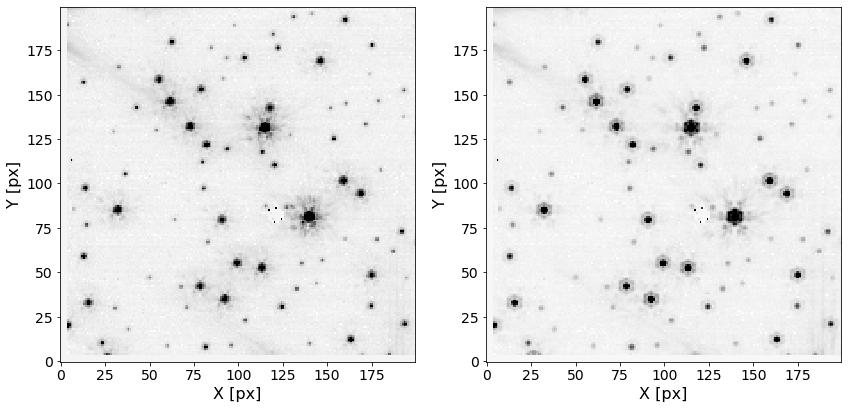

In [7]:
position = (100,100)
size = 200 * u.pixel

cutout_f115w = Cutout2D(data_f115w, position, size)
cutout_f200w = Cutout2D(data_f200w, position, size)

plt.figure(figsize=(14,14))

ax1 = plt.subplot(1,2,1)

norm_f115w_cutout = simple_norm(cutout_f115w.data, 'sqrt', percent=99.)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(cutout_f115w.data, norm=norm_f115w_cutout, cmap = 'Greys')

ax2 = plt.subplot(1,2,2)
norm_f200w_cutout = simple_norm(cutout_f200w.data, 'sqrt', percent=99.)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(cutout_f200w.data, norm=norm_f200w_cutout, cmap = 'Greys')

## Notes for developer and To Do:

Add a cell for interactive version. 

In the interactive version, the users should be able to examine the image and perform basic operations both in terms of visualization (pan, zoom, etc.) and "analysis" (select/de-select objects, derive FWHM, etc. Similar to imexam functionality). A preliminary version of this work has been already implemented and can be found in [this notebook](https://github.com/pllim/dat_pyinthesky/blob/ea838a393416b994240a7096ed8b4291aa14e406/jwst_nb_viz/NIRCam/NIRCAM_PSF_phot_ginga.ipynb). 

## Example 1: PSF Photometry using a single effective PSF

### Find Stars used to build the Effective PSF

In this example we use the photutils function [IRAFStarFinder()](https://photutils.readthedocs.io/en/latest/api/photutils.detection.IRAFStarFinder.html#photutils.detection.IRAFStarFinder). Another Possibility would be to use the function [find_peaks()](https://photutils.readthedocs.io/en/latest/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks).

For this task we need to define the following parameters:
* image's background
* fwhm of the 2D circular gaussian kernel in pixel (PSF fwhm)
* threshold above the local background (i.e., absolute image value above which to select sources). We keep a high `threshold` since we want to use only the bright stars in the field of view.  

### To Do:

Implement a mask that track the bad pixels and/or saturated pixels from the dq array, in order to exclude those regions from the data.

In [8]:
tic = time.perf_counter()

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()

sigma_psf_f115w = 0.55
sigma_psf_f200w = 0.85

std_f115w = bkgrms(data_f115w)
bkg_f115w = mmm_bkg(data_f115w)
std_f200w = bkgrms(data_f200w)
bkg_f200w = mmm_bkg(data_f200w)

psf_stars_f115w = IRAFStarFinder(threshold=500*std_f115w + bkg_f115w,
                          fwhm=sigma_psf_f115w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=10, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

psf_stars_f200w = IRAFStarFinder(threshold=500*std_f200w + bkg_f200w,
                          fwhm=sigma_psf_f200w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=10, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

sources_f115w = psf_stars_f115w(data_f115w)
sources_f200w = psf_stars_f200w(data_f200w)

toc = time.perf_counter()
print("Elapsed Time:", toc - tic, "number of sources detected for F115W:", 
      len(sources_f115w), "and for F200W:", len(sources_f200w))

Elapsed Time: 16.455834856 number of sources detected for F115W: 1449 and for F200W: 1040


### Overplot the sources on the two images

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


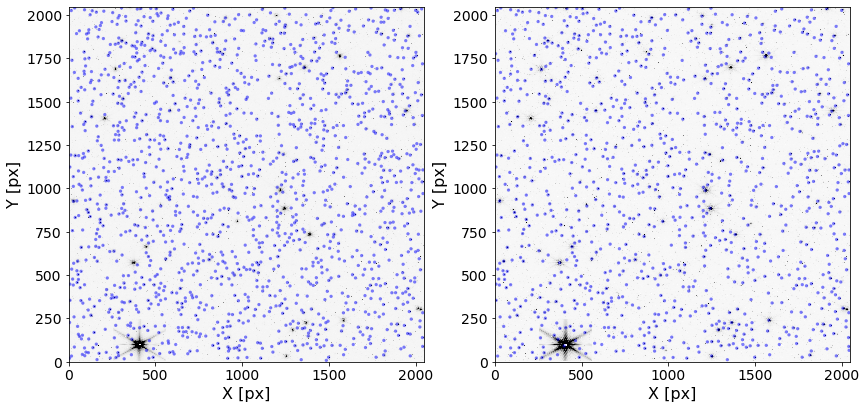

In [9]:
positions_f115w = np.transpose((sources_f115w['xcentroid'], sources_f115w['ycentroid']))
apertures_f115w = CircularAperture(positions_f115w, r=5.)

positions_f200w = np.transpose((sources_f200w['xcentroid'], sources_f200w['ycentroid']))
apertures_f200w = CircularAperture(positions_f200w, r=5.)

plt.figure(figsize=(14,14))

ax1 = plt.subplot(1,2,1)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(data_f115w, norm=norm_f115w, cmap = 'Greys', origin='lower')
apertures_f115w.plot(color='blue', lw=1.5, alpha=0.5)

ax2 = plt.subplot(1,2,2)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(data_f200w, norm=norm_f200w, cmap = 'Greys', origin='lower')
apertures_f200w.plot(color='blue', lw=1.5, alpha=0.5)

### Create the effective PSF

* Extract cutouts of the stars selected above (excluding stars too close to the image boundaries, depending on the size of the cutout)
* subtract the background from the image (create a copy of the image because photometry is peformed on images not-background subtracted)
* Create the Effective PSF using the [EPSFBuilder](https://photutils.readthedocs.io/en/latest/epsf.html) function

In [10]:
size_f115w = 25
hsize_f115w = (size_f115w - 1) / 2
size_f200w = 25
hsize_f200w = (size_f200w - 1) / 2

x_f115w = sources_f115w['xcentroid']  
y_f115w = sources_f115w['ycentroid']  
mask_f115w = ((x_f115w > hsize_f115w) & (x_f115w < (data_f115w.shape[1] -1 - hsize_f115w)) &
        (y_f115w > hsize_f115w) & (y_f115w < (data_f115w.shape[0] -1 - hsize_f115w)))

x_f200w = sources_f200w['xcentroid']  
y_f200w = sources_f200w['ycentroid']  
mask_f200w = ((x_f200w > hsize_f200w) & (x_f200w < (data_f200w.shape[1] -1 - hsize_f200w)) &
        (y_f200w > hsize_f200w) & (y_f200w < (data_f200w.shape[0] -1 - hsize_f200w)))

stars_tbl_f115w = Table()
stars_tbl_f115w['x'] = x_f115w[mask_f115w]  
stars_tbl_f115w['y'] = y_f115w[mask_f115w]  
stars_tbl_f200w = Table()
stars_tbl_f200w['x'] = x_f200w[mask_f200w]  
stars_tbl_f200w['y'] = y_f200w[mask_f200w]  

data_f115w_bkgsub = data_f115w.copy()
data_f200w_bkgsub = data_f200w.copy()

data_f115w_bkgsub -= bkg_f115w
data_f200w_bkgsub -= bkg_f200w

nddata_f115w = NDData(data = data_f115w_bkgsub)
nddata_f200w = NDData(data = data_f200w_bkgsub)

stars_f115w = extract_stars(nddata_f115w, stars_tbl_f115w, size=size_f115w)
stars_f200w = extract_stars(nddata_f200w, stars_tbl_f200w, size=size_f200w)

**Note**: Here we limit the maximum number of iterations to 3 (to limit its run time), but in practice one should use about 10 or more iterations.

In [11]:
tic = time.perf_counter()

epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)

epsf_f115w, fitted_stars_f115w = epsf_builder(stars_f115w)
epsf_f200w, fitted_stars_f200w = epsf_builder(stars_f200w)
toc = time.perf_counter()

print("Elapsed Time:", toc - tic)

Elapsed Time: 104.335139296


### Display the effective PSFs

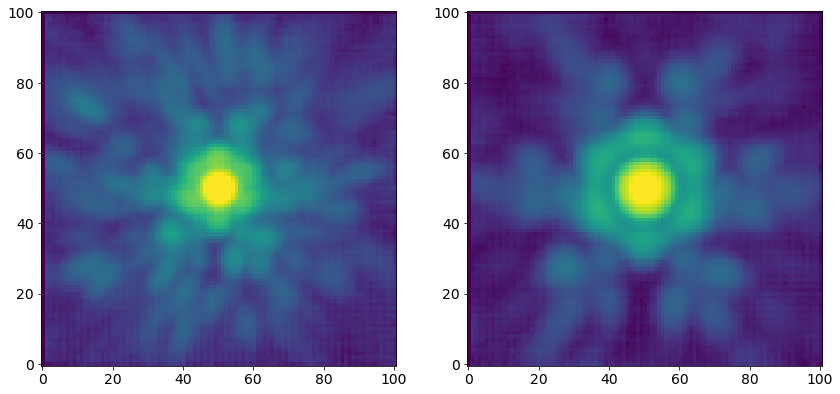

In [12]:
plt.figure(figsize=(14,14))

ax1 = plt.subplot(1,2,1)
norm_epsf1 = simple_norm(epsf_f115w.data, 'log', percent=99.)
ax1.imshow(epsf_f115w.data, norm=norm_epsf1)

ax2 = plt.subplot(1,2,2)
norm_epsf2 = simple_norm(epsf_f200w.data, 'log', percent=99.)
ax2.imshow(epsf_f200w.data, norm=norm_epsf2)

### Note for developers and To Do:

For very sparse fields or when the users want to derive the effective PSF for a specific region of the sky, it would be great to have an interactive display that shows the stars selected to build the effective PSF, with the possibility to keep or discard each star. This is obviously intended only for the cases where the number of stars to inspect is quite low. 

Below we report a possible example using the 2D cutout, thus decreasing the number of stars used to derive the effective PSF to a very low number. In this example, we find the stars in the cutout using [find_peaks()](https://photutils.readthedocs.io/en/latest/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) and we show how it is possible to display them (non-interactively). Note that [find_peaks()](https://photutils.readthedocs.io/en/latest/api/photutils.detection.find_peaks.html#photutils.detection.find_peaks) allows to set the parameter `box_size` that define the local region where the peaks above the `threshold` are found (i.e., the defined region imposes a mimimum separation between peaks). 

In the non-interactive version, to remove stars from the sample used to build the effective PSF, they must be excluded manually from the original table.

### Find stars in the 2D cutout

In [13]:
std_f115w_cutout = bkgrms(cutout_f115w.data)
bkg_f115w_cutout = mmm_bkg(cutout_f115w.data)
std_f200w_cutout = bkgrms(cutout_f200w.data)
bkg_f200w_cutout = mmm_bkg(cutout_f200w.data)

psf_stars_f115w_cutout = find_peaks(cutout_f115w.data, threshold = 500*std_f115w_cutout + bkg_f115w_cutout, 
                                    box_size = 20, centroid_func = centroid_2dg)

psf_stars_f200w_cutout = find_peaks(cutout_f200w.data, threshold = 350*std_f200w_cutout + bkg_f200w_cutout, 
                                    box_size = 20, centroid_func = centroid_2dg)

print("Number of sources detected for F115W", len(psf_stars_f115w_cutout), "and F200W:", len(psf_stars_f200w_cutout))

Number of sources detected for F115W 19 and F200W: 19


### Overplot stars in the images

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


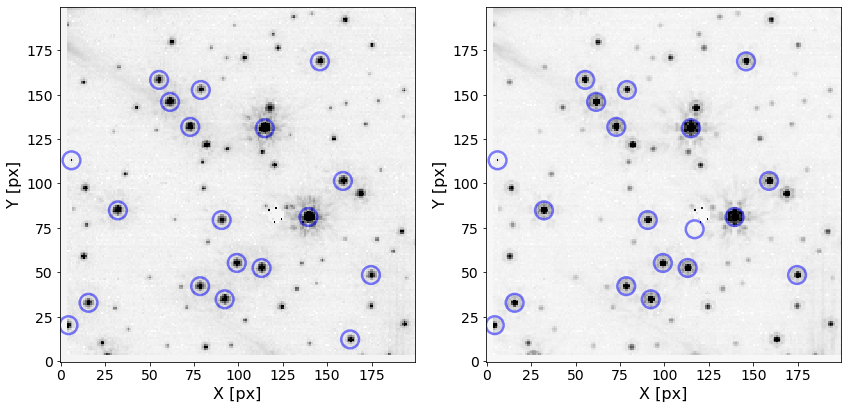

In [14]:
positions_f115w_cutout = np.transpose((psf_stars_f115w_cutout['x_centroid'], psf_stars_f115w_cutout['y_centroid']))
apertures_f115w_cutout = CircularAperture(positions_f115w_cutout, r=5.)

positions_f200w_cutout = np.transpose((psf_stars_f200w_cutout['x_centroid'], psf_stars_f200w_cutout['y_centroid']))
apertures_f200w_cutout = CircularAperture(positions_f200w_cutout, r=5.)

plt.figure(figsize=(14,14))

ax1 = plt.subplot(1,2,1)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(cutout_f115w.data, norm=norm_f115w_cutout, cmap = 'Greys', origin='lower')
apertures_f115w_cutout.plot(color='blue', lw=2.5, alpha=0.5)

ax2 = plt.subplot(1,2,2)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(cutout_f200w.data, norm=norm_f200w_cutout, cmap = 'Greys', origin='lower')
apertures_f200w_cutout.plot(color='blue', lw=2.5, alpha=0.5)

In [15]:
x_f115w_cutout = psf_stars_f115w_cutout['x_centroid']  
y_f115w_cutout = psf_stars_f115w_cutout['y_centroid'] 
mask_f115w_cutout = ((x_f115w_cutout > hsize_f115w) & (x_f115w_cutout < (cutout_f115w.shape[1] -1 - hsize_f115w)) &
        (y_f115w_cutout > hsize_f115w) & (y_f115w_cutout < (cutout_f115w.shape[0] -1 - hsize_f115w)))

x_f200w_cutout = psf_stars_f200w_cutout['x_centroid']  
y_f200w_cutout = psf_stars_f200w_cutout['y_centroid'] 
mask_f200w_cutout = ((x_f200w_cutout > hsize_f200w) & (x_f200w_cutout < (cutout_f200w.shape[1] -1 - hsize_f200w)) &
        (y_f200w_cutout > hsize_f200w) & (y_f200w_cutout < (cutout_f200w.shape[0] -1 - hsize_f200w)))

stars_tbl_f115w_cutout = Table()
stars_tbl_f115w_cutout['x'] = x_f115w_cutout[mask_f115w_cutout]  
stars_tbl_f115w_cutout['y'] = y_f115w_cutout[mask_f115w_cutout]  
stars_tbl_f200w_cutout = Table()
stars_tbl_f200w_cutout['x'] = x_f200w_cutout[mask_f200w_cutout]  
stars_tbl_f200w_cutout['y'] = y_f200w_cutout[mask_f200w_cutout]  

data_f115w_cutout_bkgsub = cutout_f115w.data.copy()
data_f200w_cutout_bkgsub = cutout_f200w.data.copy()

data_f115w_cutout_bkgsub -= bkg_f115w_cutout
data_f200w_cutout_bkgsub -= bkg_f200w_cutout

nddata_f115w_cutout = NDData(data = data_f115w_cutout_bkgsub)
nddata_f200w_cutout = NDData(data = data_f200w_cutout_bkgsub)

stars_f115w_cutout = extract_stars(nddata_f115w_cutout, stars_tbl_f115w_cutout, size=size_f115w)
stars_f200w_cutout = extract_stars(nddata_f200w_cutout, stars_tbl_f200w_cutout, size=size_f200w)

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


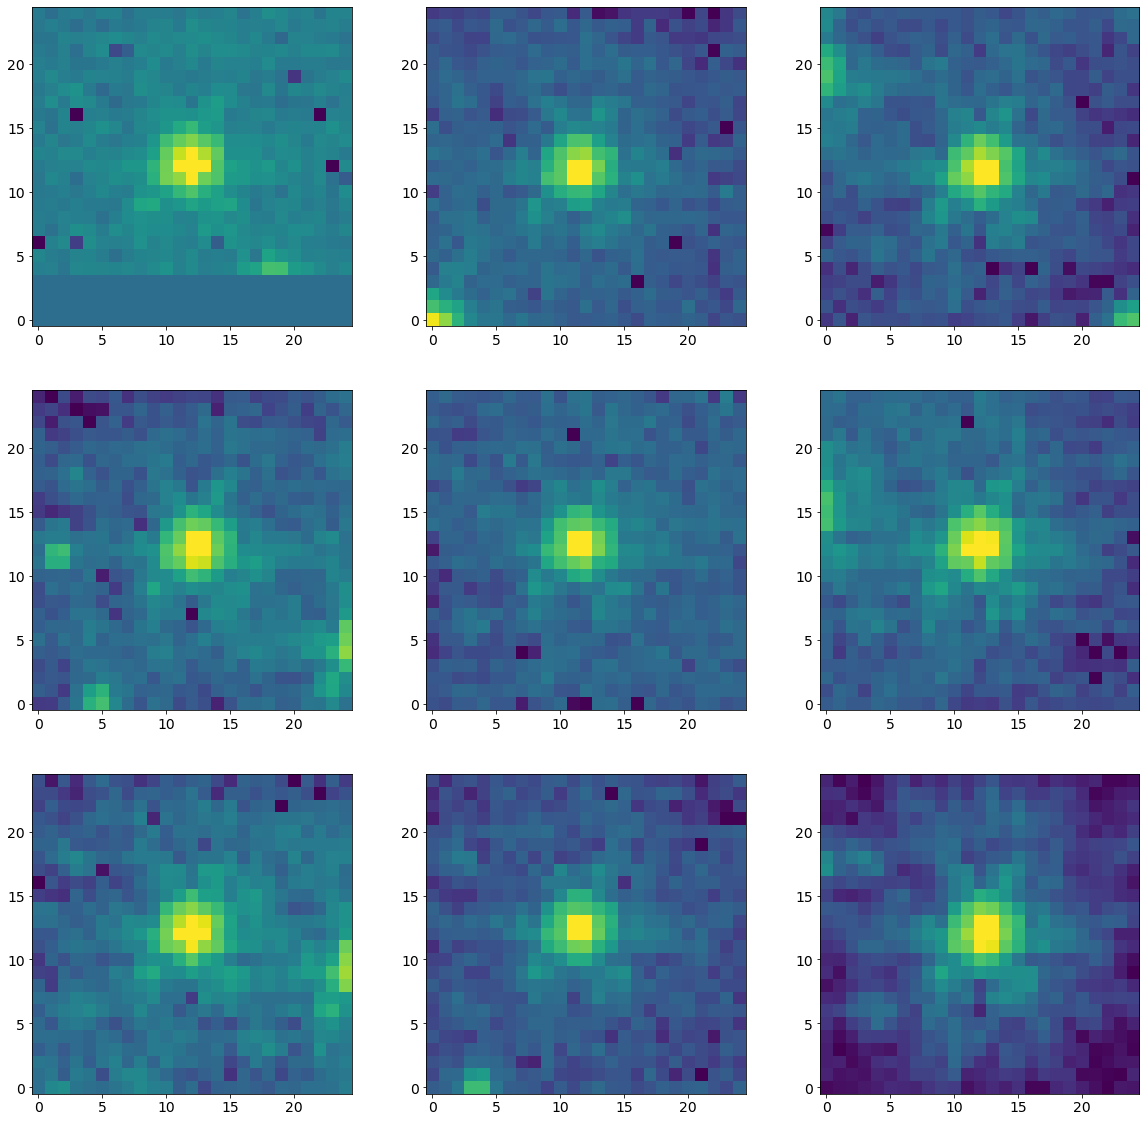

In [16]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars_f115w_cutout[i], 'log', percent=99.)
    ax[i].imshow(stars_f115w_cutout[i], norm=norm) 

## Note for developers and To Do:

### Build a function to create a grid of ePSF

Two functions:
* count PSF stars in the grid 
* create a gridded ePSF

The purpose of the first function is to count how many good PSF stars are in each sub-region defined by the grid number N. The function should start from the number provided by the user and iterate until the minimum grid size 2x2. The function could be something like:

* def count_psfstars(filename = table, number = N, save = False)
    * filename: table obtained from my_finder 
    * number: maximum number of the fiducial point for the grid (i.e. number = 4 will create a 4 x 4 grid and 16 fiducial point). The function will iterate from N x N to 2 x 2. 
    * save: if False (default), the function cycle through the different grid size and print the number of PSF stars in each subregion of the grid (i.e., if number = 4, it will print the number of PSF stars found in each subregion of the 4x4, 3x3, and 2x2 grid). If True the function create N x N tables, 1 for each subregion, containing the PSF stars that will be used to create the effective PSFs.

The second function is a loop over the different source catalogs that creates a grid of PSFs with EPSFBuilder. The function will return a a GriddedEPSFModel object containing a 3D array of N  ×  n  ×  n. The 3D array represents the N number of 2D n  ×  n ePSFs created. It should include a grid_xypos key which will state the position of the PSF on the detector for each of the PSFs. The order of the tuples in grid_xypos refers to the number the PSF is in the 3D array.

## Perform PSF Photometry

**Note**: still working on the parameter optimization

In [17]:
iraffind_f115w = IRAFStarFinder(threshold=5*std_f115w_cutout + bkg_f115w_cutout,
                          fwhm=sigma_psf_f115w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

iraffind_f200w = IRAFStarFinder(threshold=5*std_f200w_cutout + bkg_f200w_cutout,
                          fwhm=sigma_psf_f200w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

daogroup_f115w = DAOGroup(5.0*sigma_psf_f115w*gaussian_sigma_to_fwhm)
daogroup_f200w = DAOGroup(5.0*sigma_psf_f200w*gaussian_sigma_to_fwhm)

fitter = LevMarLSQFitter()

psf_model_f115w = epsf_f115w.copy()
psf_model_f200w = epsf_f200w.copy()


tic = time.perf_counter()
phot_f115w = IterativelySubtractedPSFPhotometry(finder=iraffind_f115w, group_maker=daogroup_f115w,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model_f115w,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11), aperture_radius = 3)

result_tab_f115w = phot_f115w(cutout_f115w.data)

toc = time.perf_counter()

print("Time elapsed:", toc - tic, "Number of sources detected in F115W:", len(result_tab_f115w))

tic = time.perf_counter()

phot_f200w = IterativelySubtractedPSFPhotometry(finder=iraffind_f200w, group_maker=daogroup_f200w,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model_f200w,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11), aperture_radius = 4)

result_tab_f200w = phot_f200w(cutout_f200w.data)

toc = time.perf_counter()

print("Time elapsed:", toc - tic,  "Number of sources detected in F200W:", len(result_tab_f200w))

Time elapsed: 4.676815497999996 Number of sources detected in F115W: 193


Time elapsed: 8.725022501000012 Number of sources detected in F200W: 263


**Note**: cell below is for the photometry of the whole field. Run time for the F115W is ~ 25 min, whereas reduction of the F200W image fails with the following error message: 

*RecursionError: maximum recursion depth exceeded while calling a Python object*

To run the photometry on the whole field, uncomment cell below. 

In [18]:
#iraffind_f115w = IRAFStarFinder(threshold=5*std_f115w + bkg_f115w,
                          #fwhm=sigma_psf_f115w*gaussian_sigma_to_fwhm,
                          #minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          #sharplo=0.30, sharphi=1.40)

#iraffind_f200w = IRAFStarFinder(threshold=5*std_f200w + bkg_f200w,
                          #fwhm=sigma_psf_f200w*gaussian_sigma_to_fwhm,
                          #minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          #sharplo=0.30, sharphi=1.40)

#tic = time.perf_counter()
#phot_f115w = IterativelySubtractedPSFPhotometry(finder=iraffind_f115w, group_maker=daogroup_f115w,
                                                #bkg_estimator=mmm_bkg, psf_model=psf_model_f115w,
                                                #fitter=LevMarLSQFitter(),
                                                #niters=2, fitshape=(11,11), aperture_radius = 3)

#result_tab_f115w = phot_f115w(data_f115w)

#toc = time.perf_counter()

#print("Time elapsed:", toc - tic, "Number of sources detected in F115W:", len(result_tab_f115w))

#tic = time.perf_counter()

#phot_f200w = IterativelySubtractedPSFPhotometry(finder=iraffind_f200w, group_maker=daogroup_f200w,
                                                #bkg_estimator=mmm_bkg, psf_model=psf_model_f200w,
                                                #fitter=LevMarLSQFitter(),
                                                #niters=2, fitshape=(11,11), aperture_radius = 4)

#result_tab_f200w = phot_f200w(data_f200w)

### Display subtracted image

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


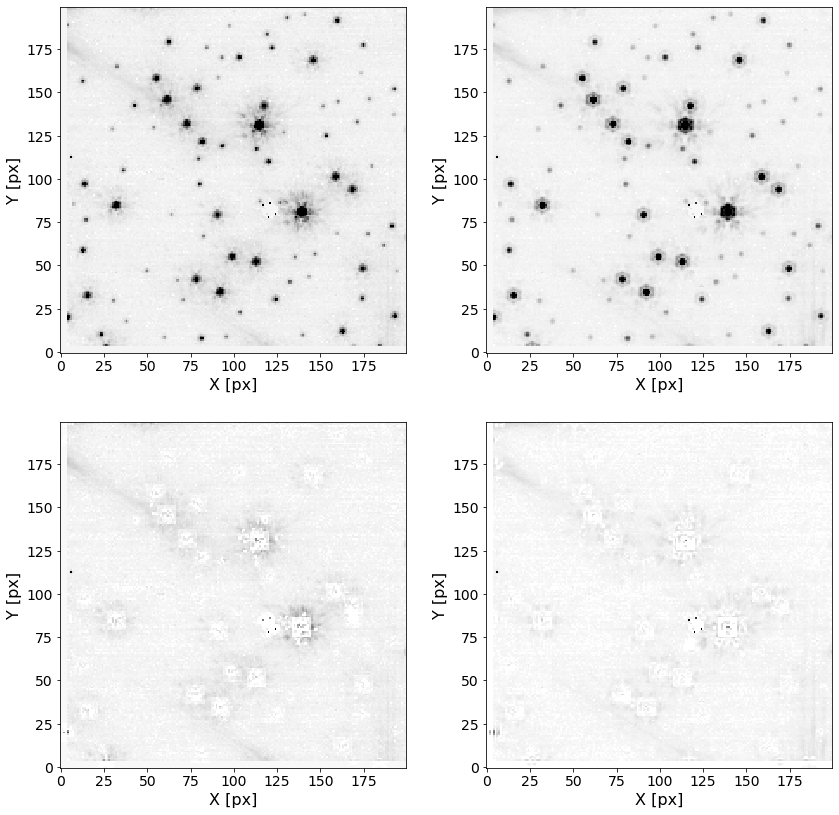

In [19]:
diff_f115w = phot_f115w.get_residual_image()
diff_f200w = phot_f200w.get_residual_image()

plt.figure(figsize=(14,14))

ax1 = plt.subplot(2,2,1)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(cutout_f115w.data, norm=norm_f115w_cutout, cmap = 'Greys')

ax2 = plt.subplot(2,2,2)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(cutout_f200w.data, norm=norm_f200w_cutout, cmap = 'Greys')

ax3 = plt.subplot(2,2,3)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax3.imshow(diff_f115w, norm=norm_f115w_cutout, cmap = 'Greys')

ax4 = plt.subplot(2,2,4)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax4.imshow(diff_f200w, norm=norm_f200w_cutout, cmap = 'Greys')


## Example 2: PSF Photometry using a grid of fiducial PSFs from WebbPSF

**Note**: I was unable to run the photometry using a grid of PSFs (i.e., I killed the process after 4 hours when it was still going through the first iteration). 

I show below how to create a grid of PSFs with WebbPSF and then I will perform the photometry on the cutout using a single PSF obtained for the position (x,y) = (100,100). Note that also using a single PSF the photometry step takes several minutes.  

In [20]:
nrc = webbpsf.NIRCam()
nrc.filter = "F115W"
nrc.detector = "NRCB1"

# number of PSF to create 
num = 16

grid_f115w = nrc.psf_grid(num_psfs = num, all_detectors = False, save = True)

nrc.filter = "F200W"

grid_f200w = nrc.psf_grid(num_psfs = num, all_detectors = False, save = True)


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 1/16: (0, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 2/16: (0, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 3/16: (0, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 4/16: (0, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 5/16: (682, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 6/16: (682, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 7/16: (682, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 8/16: (682, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 9/16: (1365, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 10/16: (1365, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 11/16: (1365, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 12/16: (1365, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 13/16: (2047, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 14/16: (2047, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 15/16: (2047, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 16/16: (2047, 2047) pixels
  Saving file: nircam_nrcb1_f115w_fovp101_samp4_npsf16.fits

Running instrument: NIRCam, filter: F200W
  Running detector: NRCB1


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 1/16: (0, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 2/16: (0, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 3/16: (0, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 4/16: (0, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 5/16: (682, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 6/16: (682, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 7/16: (682, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 8/16: (682, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 9/16: (1365, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 10/16: (1365, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 11/16: (1365, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 12/16: (1365, 2047) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 13/16: (2047, 0) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 14/16: (2047, 682) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 15/16: (2047, 1365) pixels


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 16/16: (2047, 2047) pixels
  Saving file: nircam_nrcb1_f200w_fovp101_samp4_npsf16.fits


To use the grid of PSFs uncomment cell below.

**Note the warning above about the runtime**

In [21]:
#psfs_webbpsf_f115w = grid_f115w.copy()
#psfs_webbpsf_f200w = grid_f200w.copy()

#iraffind_f115w = IRAFStarFinder(threshold=5*std_f115w + bkg_f115w,
                          #fwhm=sigma_psf_f115w*gaussian_sigma_to_fwhm,
                          #minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          #sharplo=0.30, sharphi=1.40)

#iraffind_f200w = IRAFStarFinder(threshold=5*std_f200w + bkg_f200w,
                          #fwhm=sigma_psf_f200w*gaussian_sigma_to_fwhm,
                          #minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          #sharplo=0.30, sharphi=1.40)

#tic = time.perf_counter()
#phot_f115w_grid = IterativelySubtractedPSFPhotometry(finder=iraffind_f115w, group_maker=daogroup_f115w,
                                                #bkg_estimator=mmm_bkg, psf_model=psfs_webbpsf_f115w,
                                                #fitter=LevMarLSQFitter(),
                                                #niters=2, fitshape=(11,11), aperture_radius = 3)

#result_tab_f115w_grid = phot_f115w_grid(data_f115w)

#toc = time.perf_counter()

#print("Time elapsed:", toc - tic, "Number of sources detected in F115W:", len(result_tab_f115w))

#tic = time.perf_counter()

#phot_f200w_grid = IterativelySubtractedPSFPhotometry(finder=iraffind_f200w, group_maker=daogroup_f200w,
                                                #bkg_estimator=mmm_bkg, psf_model=psfs_webbpsf_f200w,
                                                #fitter=LevMarLSQFitter(),
                                                #niters=2, fitshape=(11,11), aperture_radius = 4)

#result_tab_f200w_grid = phot_f200w_grid(data_f200w)


In [22]:
nrc = webbpsf.NIRCam()

nrc.filter = "F115W"
nrc.detector = "NRCB1"

# number of PSF to create 
num = 1
nrc.detector_position = (100,100)
single_f115w = nrc.psf_grid(num_psfs = num, all_detectors = False, fov_pixels = 15, single_psf_centered = False)

nrc.filter = "F200W"

single_f200w = nrc.psf_grid(num_psfs = num, all_detectors = False, fov_pixels = 15, single_psf_centered = False)


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 1/1: (100, 100) pixels

Running instrument: NIRCam, filter: F200W
  Running detector: NRCB1


Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 21 steps


    Position 1/1: (100, 100) pixels


### Perform Photometry on the cutout images using the model PSF from WebbPSF

In [23]:
iraffind_f115w = IRAFStarFinder(threshold=5*std_f115w_cutout + bkg_f115w_cutout,
                          fwhm=sigma_psf_f115w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

iraffind_f200w = IRAFStarFinder(threshold=5*std_f200w_cutout + bkg_f200w_cutout,
                          fwhm=sigma_psf_f200w*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.5, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

daogroup_f115w = DAOGroup(5.0*sigma_psf_f115w*gaussian_sigma_to_fwhm)
daogroup_f200w = DAOGroup(5.0*sigma_psf_f200w*gaussian_sigma_to_fwhm)

fitter = LevMarLSQFitter()

psf_single_f115w = single_f115w.copy()
psf_single_f200w = single_f200w.copy()

tic = time.perf_counter()
phot_f115w_webbpsf_single = IterativelySubtractedPSFPhotometry(finder=iraffind_f115w, group_maker=daogroup_f115w,
                                                bkg_estimator=mmm_bkg, psf_model=psf_single_f115w,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11), aperture_radius = 3)

result_tab_f115w_webbpsf_single = phot_f115w_webbpsf_single(cutout_f115w.data)

toc = time.perf_counter()

print("Time elapsed:", toc - tic, "Number of sources detected in F115W:", len(result_tab_f115w_webbpsf_single))

tic = time.perf_counter()

phot_f200w_webbpsf_single = IterativelySubtractedPSFPhotometry(finder=iraffind_f200w, group_maker=daogroup_f200w,
                                                bkg_estimator=mmm_bkg, psf_model=psf_single_f200w,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11), aperture_radius = 4)

result_tab_f200w_webbpsf_single = phot_f200w_webbpsf_single(cutout_f200w.data)

toc = time.perf_counter()

print("Time elapsed:", toc - tic,  "Number of sources detected in F200W:", len(result_tab_f200w_webbpsf_single))

Time elapsed: 14.996730431999993 Number of sources detected in F115W: 215


Time elapsed: 29.245058868 Number of sources detected in F200W: 322


### Display the subtracted images

/Users/jcurtin/workspace/jdat_notebooks/notebooks/psf_photometry/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


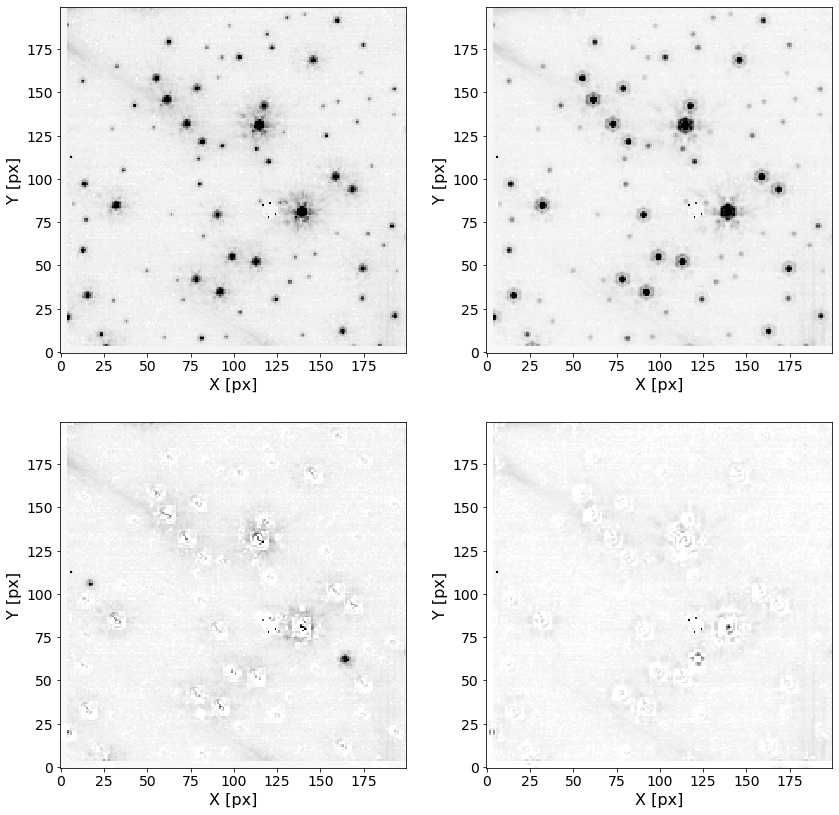

In [24]:
diff_f115w_webbpsf_single = phot_f115w_webbpsf_single.get_residual_image()
diff_f200w_webbpsf_single = phot_f200w_webbpsf_single.get_residual_image()

plt.figure(figsize=(14,14))

ax1 = plt.subplot(2,2,1)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax1.imshow(cutout_f115w.data, norm=norm_f115w_cutout, cmap = 'Greys')

ax2 = plt.subplot(2,2,2)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax2.imshow(cutout_f200w.data, norm=norm_f200w_cutout, cmap = 'Greys')

ax3 = plt.subplot(2,2,3)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax3.imshow(diff_f115w_webbpsf_single, norm=norm_f115w_cutout, cmap = 'Greys')

ax4 = plt.subplot(2,2,4)
plt.xlabel("X [px]")
plt.ylabel("Y [px]")
ax4.imshow(diff_f200w_webbpsf_single, norm=norm_f200w_cutout, cmap = 'Greys')


## Preliminary Test: Color-Magnitude Diagram

Comparison between the PSF photometry and the input stars

### Select stars with positive flux and convert to magnitudes

In [25]:
# ePSF 

flux_f115w = result_tab_f115w['flux_fit']
x_f115w = result_tab_f115w['x_fit']
y_f115w = result_tab_f115w['y_fit']

mask_goodstar_f115w = (flux_f115w > 0)

mag_det_f115w = -2.5 * np.log10(flux_f115w[mask_goodstar_f115w])
x_det_f115w = x_f115w[mask_goodstar_f115w]
y_det_f115w = y_f115w[mask_goodstar_f115w]


flux_f200w = result_tab_f200w['flux_fit']
x_f200w = result_tab_f200w['x_fit']
y_f200w = result_tab_f200w['y_fit']

mask_goodstar_f200w = (flux_f200w > 0)
mag_det_f200w = -2.5 * np.log10(flux_f200w[mask_goodstar_f200w])
x_det_f200w = x_f200w[mask_goodstar_f200w]
y_det_f200w = y_f200w[mask_goodstar_f200w]

flux_f115w = result_tab_f115w['flux_fit']
x_f115w = result_tab_f115w['x_fit']
y_f115w = result_tab_f115w['y_fit']

# WebbPSF

flux_f115w_webbpsf = result_tab_f115w_webbpsf_single['flux_fit']
x_f115w_webbpsf = result_tab_f115w_webbpsf_single['x_fit']
y_f115w_webbpsf = result_tab_f115w_webbpsf_single['y_fit']

mask_goodstar_f115w_webbpsf = (flux_f115w_webbpsf > 0)

mag_det_f115w_webbpsf = -2.5 * np.log10(flux_f115w_webbpsf[mask_goodstar_f115w_webbpsf])
x_det_f115w_webbpsf = x_f115w_webbpsf[mask_goodstar_f115w_webbpsf]
y_det_f115w_webbpsf = y_f115w_webbpsf[mask_goodstar_f115w_webbpsf]

flux_f200w_webbpsf = result_tab_f200w_webbpsf_single['flux_fit']
x_f200w_webbpsf = result_tab_f200w_webbpsf_single['x_fit']
y_f200w_webbpsf = result_tab_f200w_webbpsf_single['y_fit']

mask_goodstar_f200w_webbpsf = (flux_f200w_webbpsf > 0)
mag_det_f200w_webbpsf = -2.5 * np.log10(flux_f200w_webbpsf[mask_goodstar_f200w_webbpsf])
x_det_f200w_webbpsf = x_f200w_webbpsf[mask_goodstar_f200w_webbpsf]
y_det_f200w_webbpsf = y_f200w_webbpsf[mask_goodstar_f200w_webbpsf]

### Cross-match the catalogs

In [26]:
radec_f115w = pixel_to_skycoord(x_det_f115w, y_det_f115w, imwcs_f115w, origin=0, cls=None)
radec_f200w = pixel_to_skycoord(x_det_f200w, y_det_f200w, imwcs_f200w, origin=0, cls=None)

idx, d2d, d3d = match_coordinates_sky(radec_f115w, radec_f200w)

max_sep = 0.015 * u.arcsec
sep_constraint = d2d < max_sep
f115w_matches = radec_f115w[sep_constraint]
f200w_matches = radec_f200w[idx[sep_constraint]]
print("Number of matched sources:", len(f115w_matches))

radec_f115w_webbpsf = pixel_to_skycoord(x_det_f115w_webbpsf, y_det_f115w_webbpsf, imwcs_f115w, origin=0, cls=None)
radec_f200w_webbpsf = pixel_to_skycoord(x_det_f200w_webbpsf, y_det_f200w_webbpsf, imwcs_f200w, origin=0, cls=None)

idx_webbpsf, d2d_webbpsf, d3d_webbpsf = match_coordinates_sky(radec_f115w_webbpsf, radec_f200w_webbpsf)

sep_constraint_webbpsf = d2d_webbpsf < max_sep
f115w_matches_webbpsf = radec_f115w_webbpsf[sep_constraint_webbpsf]
f200w_matches_webbpsf = radec_f200w_webbpsf[idx_webbpsf[sep_constraint_webbpsf]]
print("Number of matched sources:", len(f115w_matches_webbpsf))

F115W_epsf = mag_det_f115w[sep_constraint]
F200W_epsf = mag_det_f200w[idx[sep_constraint]]
F115W_webbpsf = mag_det_f115w_webbpsf[sep_constraint_webbpsf]
F200W_webbpsf = mag_det_f200w_webbpsf[idx_webbpsf[sep_constraint_webbpsf]]

Number of matched sources: 90
Number of matched sources: 92


### Import the LMC calibration field catalog and select the objects in the 2D cutout

In [27]:
input_cat1 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/psf_photometry/jw01072001001_01101_00001_nrcb1_uncal_pointsources.list' 

cat_f115w = pd.read_csv(input_cat1, header = None, sep='\s+', names=['x_f115w','y_f115w','f115w_in'], comment='#',
                        skiprows=0, usecols=(5,6,7))

input_cat2 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/psf_photometry/jw01072001001_01101_00005_nrcb1_uncal_pointsources.list' 

cat_f200w = pd.read_csv(input_cat2, header = None, sep='\s+', names=['x_f200w','y_f200w','f200w_in'], comment='#',
                        skiprows=0, usecols=(5,6,7))

cat_f115w_sel = cat_f115w[(cat_f115w['x_f115w'] > 0) & (cat_f115w['x_f115w'] < 200) 
                          & (cat_f115w['y_f115w'] > 0) & (cat_f115w['y_f115w'] < 200)]

cat_f200w_sel = cat_f200w[(cat_f200w['x_f200w'] > 0) & (cat_f200w['x_f200w'] < 200) 
                          & (cat_f200w['y_f200w'] > 0) & (cat_f200w['y_f200w'] < 200)]

### Plot the Color-Magnitude Diagrams

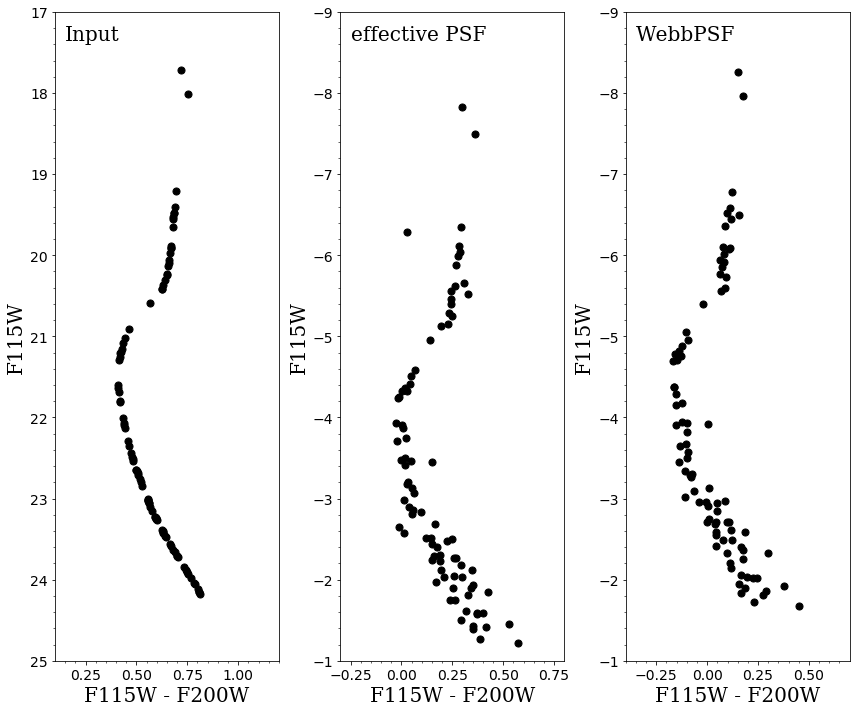

In [28]:
plt.figure(figsize=(12,10))
plt.clf()

font1 = {'family' : 'serif',
      'color': 'black',
      'weight': 'normal',
      'size': '12'}

font2 = {'family' : 'serif',
      'color': 'black',
      'weight': 'normal',
      'size': '20'}

ax1 = plt.subplot(1,3,1)

xlim0 = 0.1
xlim1 = 1.2
ylim0 = 25 
ylim1 = 17

ax1.set_xlim(xlim0,xlim1)
ax1.set_ylim(ylim0,ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(cat_f115w_sel['f115w_in'] - cat_f200w_sel['f200w_in'], cat_f115w_sel['f115w_in'] , s = 50, color = 'k')

ax1.set_xlabel("F115W - F200W", fontdict = font2)
ax1.set_ylabel("F115W", fontdict = font2)
ax1.text(0.15, 17.35, "Input", fontdict = font2)

ax2 = plt.subplot(1,3,2)

xlim0 = -0.3
xlim1 = 0.8
ylim0 = -1 
ylim1 = -9

ax2.set_xlim(xlim0,xlim1)
ax2.set_ylim(ylim0,ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(F115W_epsf - F200W_epsf, F115W_epsf, s = 50, color = 'k')
ax2.text(-0.25, -8.65, "effective PSF", fontdict = font2)

ax2.set_xlabel("F115W - F200W", fontdict = font2)
ax2.set_ylabel("F115W", fontdict = font2)

ax3 = plt.subplot(1,3,3)

xlim0 = -0.4
xlim1 = 0.7
ylim0 = -1 
ylim1 = -9

ax3.set_xlim(xlim0,xlim1)
ax3.set_ylim(ylim0,ylim1)

ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_locator(ticker.AutoLocator())
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax3.scatter(F115W_webbpsf - F200W_webbpsf, F115W_webbpsf, s = 50, color = 'k')
ax3.text(-0.35, -8.65, "WebbPSF", fontdict = font2)

ax3.set_xlabel("F115W - F200W", fontdict = font2)
ax3.set_ylabel("F115W", fontdict = font2)

plt.tight_layout()